# Project Proposal


## Introduction
Rice is one of the most popular grain products in the world and it plays an important role in both nutrition and cultural and regional agriculture. There are many species of rice that are grown in different countries and different species can be distinguished by many characteristics such as physical properties, cooking features, taste, and others. These characteristics are usually used for quality criteria examination or determination of various types. However, it might be inefficient to proceed using some of these characteristics. Therefore, according to many studies, physical properties are found to be useful and less time-consuming.

In our project, we will concentrate on the prediction of different rice types based on information on the appearance of the rice and its accuracy. We will focus on two rice species in Turkey—Osmancik and Cammeo—as well as several physical properties of each species. In general, these two species are distinct in shape, texture, and color. This thus poses the question:

**What is the classification accuracy of using the K-Nearest Neighbors model to predict that rice is Osmancik or Cammeo?**

We will seek to answer this question by using the Rice (Cammeo and Osmancik) Data Set. This data set includes certified rice samples in both species collected by Ilkay Cinar and Murat Koklu in Turkey. The data was obtained and calculated by taking images of the two species. It contains seven numeric variables: Area, Perimeter, Major Axis Length, Minor Axis Length, Eccentricity, Convex Area, and Extent, and one categorical variable: Class.

## Preliminary exploratory data analysis

In [77]:
# Import packages
library(readxl)
library(tidyverse)
library(repr)
library(tidymodels)

Firstly, read the data, and obtain a general glimpse on it.

In [78]:
rice <- read_excel("Rice_Osmancik_Cammeo_Dataset.xlsx") %>%
mutate(CLASS = as_factor(CLASS))
head(rice)
glimpse(rice)
any(is.na(rice))
seed <- 1

AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
13176,458.343,193.3374,87.44839,0.8918609,13368,0.6406690,Cammeo
14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
13479,477.016,200.0531,86.65029,0.9013283,13786,0.6578973,Cammeo


Rows: 3,810
Columns: 8
$ AREA         <dbl> 15231, 14656, 14634, 13176, 14688, 13479, 15757, 16405, …
$ PERIMETER    <dbl> 525.579, 494.311, 501.122, 458.343, 507.167, 477.016, 50…
$ MAJORAXIS    <dbl> 229.7499, 206.0201, 214.1068, 193.3374, 211.7434, 200.05…
$ MINORAXIS    <dbl> 85.09379, 91.73097, 87.76829, 87.44839, 89.31245, 86.650…
$ ECCENTRICITY <dbl> 0.9288820, 0.8954050, 0.9121181, 0.8918609, 0.9066909, 0…
$ CONVEX_AREA  <dbl> 15617, 15072, 14954, 13368, 15262, 13786, 16150, 16837, …
$ EXTENT       <dbl> 0.5728955, 0.6154363, 0.6932588, 0.6406690, 0.6460239, 0…
$ CLASS        <fct> Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, Cammeo, …


[1] FALSE

It is shown that the data can be read into R, and there is no NA in the dataset.
Additionally, the data seems to be already tidy. It fulfills the requirements that there is one observation per row, one variable per column, and one value per cell.

In [79]:
set.seed(seed) 

# your code here
rice_split <- initial_split(rice, prop = 0.75, strata = CLASS)  
rice_train <- training(rice_split)   
rice_test <- testing(rice_split)

In [80]:
set.seed(seed)

rice_recipe <- recipe(CLASS ~ AREA + PERIMETER + MAJORAXIS + CONVEX_AREA, data = rice_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
rice_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [81]:
set.seed(seed)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_tune

rice_vfold <- vfold_cv(rice_train, v = 5, strata = CLASS)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


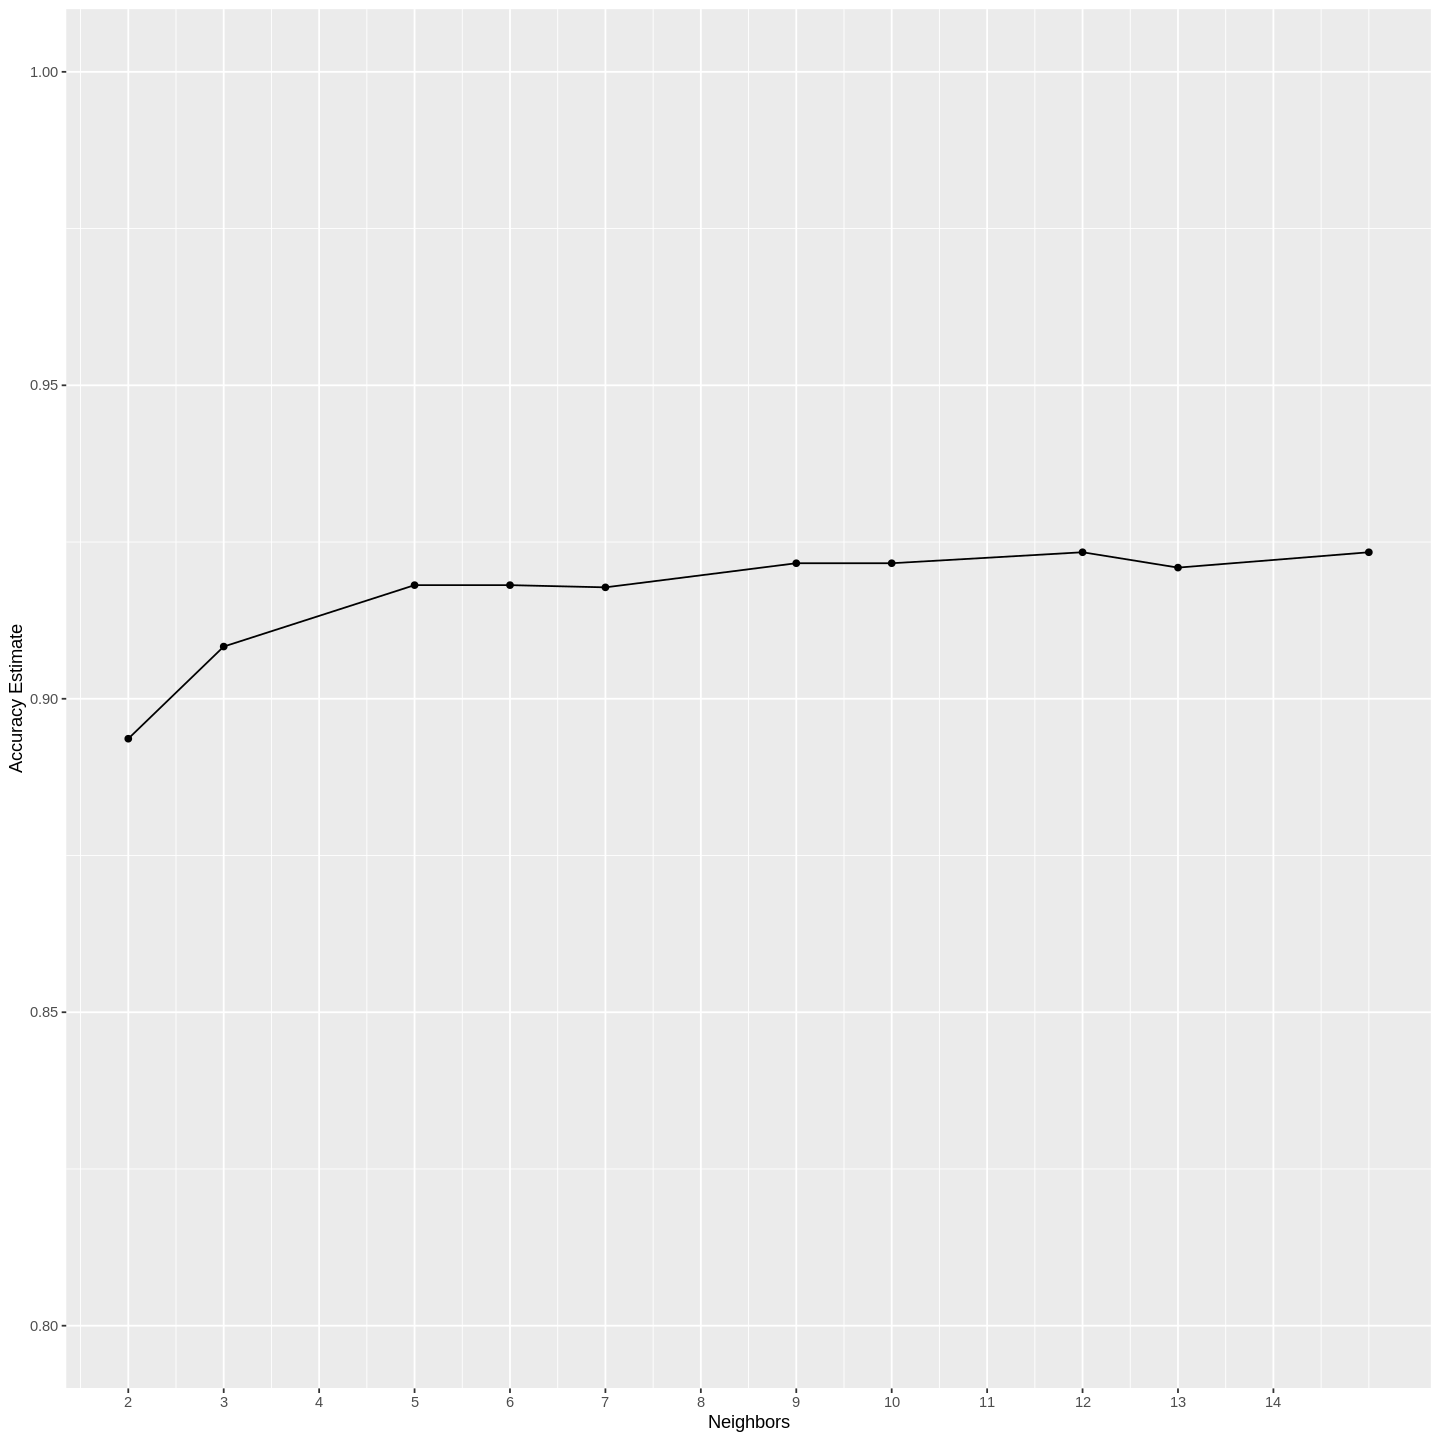

In [82]:
set.seed(seed) 

knn_results <- workflow() %>%
       add_recipe(rice_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = rice_vfold, grid = 10) %>%
       collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
       scale_y_continuous(limits = c(0.8, 1.0))
accuracy_versus_k

K = 12 seems to have the highest accuracy.

In [83]:
set.seed(seed)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
       set_engine("kknn") %>%
       set_mode("classification")
                             
rice_fit <- workflow() %>%
       add_recipe(rice_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = rice_train)

rice_test_predictions <- predict(rice_fit, rice_test) %>%
       bind_cols(rice_test)
rice_test_predictions

rice_metrics <- rice_test_predictions %>%
         metrics(truth = CLASS, estimate = .pred_class) 
rice_metrics


rice_prediction_accuracy <- rice_test_predictions %>%
         metrics(truth = CLASS, estimate = .pred_class)  
rice_prediction_accuracy

rice_mat <- rice_test_predictions %>% 
       conf_mat(truth = CLASS, estimate = .pred_class)
rice_mat

.pred_class,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cammeo,14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
Cammeo,13500,476.915,202.5467,85.40547,0.9067549,13800,0.7177033,Cammeo
Cammeo,13509,480.466,207.1372,83.94016,0.9142106,13732,0.5956349,Cammeo
Cammeo,13699,480.729,197.9709,89.94907,0.8908207,14178,0.6720467,Cammeo
Cammeo,14405,488.237,204.4301,90.62646,0.8963671,14742,0.7637858,Cammeo
Cammeo,13328,473.044,201.3989,85.25861,0.9059746,13588,0.7800995,Cammeo
Cammeo,13130,467.922,196.1468,86.20712,0.8982411,13462,0.5748183,Cammeo
Cammeo,16104,507.429,206.0707,100.75363,0.8723245,16457,0.6054136,Cammeo
Cammeo,14415,488.122,203.5928,91.03473,0.8944634,14758,0.6741021,Cammeo


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9264706
kap,binary,0.8497847


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9264706
kap,binary,0.8497847


          Truth
Prediction Cammeo Osmancik
  Cammeo      372       35
  Osmancik     35      510

Our resulting accuracy is 0.92.

## Methods
We will conduct our data analysis using the variables Major Axis Length and Eccentricity since the ggpairs plot showed that these two variables allow us to easily distinguish between the Cammeo and Osmancik data clusters. Other variables such as extent make it harder to diffrentiate between the two rices and thus would make for good predictor variables. We can visualize the data by using a facet_grid function or by making a graph with low alpha level. For both these graphs we can colour by the class of rice.

## Expected outcomes and significance
We expect to find that our predictions will be mostly accurate as shown in this project proposal. ???